# Regression Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/acetylcholinesterase-QSAR/notebooks/6-ML-algorithm.ipynb)

## 1. Import Libraries

In [1]:
!pip install rdkit-pypi

In [2]:
!pip install openpyxl

In [3]:
!pip install cairosvg

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

In [5]:
descriptors_train = pd.read_csv('/content/reduced_descriptors.csv')

In [6]:
descriptors = descriptors_train.set_index('molecule_chembl_id')

In [7]:
descriptors.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,0,0,3.960664,0,0,0,158.734616,159.496714,-111.776025,-119.364540,...,0,0,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,0,0,3.793369,0,0,0,159.752358,160.711564,-120.228923,-52.724063,...,0,0,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,0,0,3.799305,0,0,0,159.522280,160.526614,-128.211073,-53.930796,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4469239,0,0,3.799305,0,0,0,158.369845,159.102807,-109.399846,-64.755863,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,0,1,4.249602,0,0,0,155.094408,157.417355,61.824490,47.841633,...,0,0,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921


In [8]:
descriptors.shape

(5463, 226)

In [9]:
data = PandasTools.LoadSDF('/content/data_to_train.sdf', molColName='Molecule')

In [10]:
data = data.set_index('molecule_chembl_id')

In [11]:
data.head()

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b6110>
CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b5ee0>
CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b5fc0>
CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b5b60>
CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.30103,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b6260>


In [12]:
data.shape

(5463, 6)

In [13]:
data['Label'] = data['Label'].astype('int')

In [14]:
data['pIC50'] = data['pIC50'].astype('float64')

In [15]:
# Compare if the indexes are the same
indexes_are_equal = descriptors.index.equals(data.index)

print(indexes_are_equal)

True


In [16]:
combined_data = pd.concat([data[['Label', 'pIC50']], descriptors], axis=1)

In [17]:
combined_data.head()

,Label,pIC50,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,1,5.30103,0,0,3.960664,0,0,0,158.734616,159.496714,...,0,0,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,1,5.30103,0,0,3.793369,0,0,0,159.752358,160.711564,...,0,0,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,1,5.30103,0,0,3.799305,0,0,0,159.522280,160.526614,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4469239,1,5.30103,0,0,3.799305,0,0,0,158.369845,159.102807,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,1,5.30103,0,1,4.249602,0,0,0,155.094408,157.417355,...,0,0,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921


In [18]:
combined_data.to_csv('combined_data_to_split.csv', index=True)

## Data Scaling

**Scale pIC50**


---


In [19]:
pic50_scaler = StandardScaler()
scaled_pic50 = pic50_scaler.fit_transform(combined_data[['pIC50']])

In [20]:
scaled_pic50_df = pd.DataFrame(scaled_pic50, columns=['pIC50'])
scaled_pic50_df

,pIC50
0,5.207443
1,5.207443
2,5.207443
3,5.207443
4,5.207443
...,...
5458,-2.406527
5459,-2.446141
5460,-2.517664
5461,-2.573637


In [21]:
scaled_pic50_df_id = scaled_pic50_df.set_index(combined_data.index)

In [22]:
scaled_pic50_df_id

,pIC50
molecule_chembl_id,
CHEMBL4468781,5.207443
CHEMBL199670,5.207443
CHEMBL199861,5.207443
CHEMBL4469239,5.207443
CHEMBL4780352,5.207443
...,...
CHEMBL102637,-2.406527
CHEMBL334938,-2.446141
CHEMBL3597055,-2.517664


In [23]:
# Compare if the indexes are the same
indexes_are_equal = descriptors.index.equals(scaled_pic50_df_id.index)

print(indexes_are_equal)

True


In [24]:
scaled_pic50_df_id.to_csv('pIC50_train_scaled.csv', index=True)

**Features**

---


In [25]:
# Initialize the scaler
scaler = StandardScaler()

In [26]:
combined_data.head()

,Label,pIC50,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,1,5.30103,0,0,3.960664,0,0,0,158.734616,159.496714,...,0,0,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,1,5.30103,0,0,3.793369,0,0,0,159.752358,160.711564,...,0,0,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,1,5.30103,0,0,3.799305,0,0,0,159.522280,160.526614,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4469239,1,5.30103,0,0,3.799305,0,0,0,158.369845,159.102807,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,1,5.30103,0,1,4.249602,0,0,0,155.094408,157.417355,...,0,0,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921


In [27]:
data_to_scale = combined_data.drop(['Label', 'pIC50'], axis=1)
data_to_scale

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,0,0,3.960664,0,0,0,158.734616,159.496714,-111.776025,-119.364540,...,0,0,0.047814,0.039922,0.023478,0.016611,0.010863,0.008414,0.006963,0.007337
CHEMBL199670,0,0,3.793369,0,0,0,159.752358,160.711564,-120.228923,-52.724063,...,0,0,0.039701,0.029409,0.014824,0.011958,0.009629,0.005465,0.004549,0.004576
CHEMBL199861,0,0,3.799305,0,0,0,159.522280,160.526614,-128.211073,-53.930796,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4469239,0,0,3.799305,0,0,0,158.369845,159.102807,-109.399846,-64.755863,...,0,0,0.040465,0.030048,0.015194,0.012290,0.008953,0.005660,0.006030,0.006247
CHEMBL4780352,0,1,4.249602,0,0,0,155.094408,157.417355,61.824490,47.841633,...,0,0,0.045326,0.038862,0.032870,0.018058,0.010193,0.011732,0.006769,0.005921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL102637,0,1,3.079951,0,0,0,157.993536,171.997322,-56.465185,-27.585185,...,0,0,0.062500,0.026667,0.047619,0.015306,0.023438,0.000000,0.000000,0.000000
CHEMBL334938,0,1,3.668249,0,0,0,155.429370,165.836723,-77.743945,17.494810,...,0,0,0.062500,0.044848,0.043519,0.020272,0.020616,0.016427,0.005208,0.000000
CHEMBL3597055,0,0,4.786207,0,0,0,156.708939,157.001785,54.399345,-41.034266,...,0,0,0.038690,0.041503,0.025132,0.015013,0.010732,0.009173,0.007338,0.007794


In [28]:
# Scale the features
scaled_data = pd.DataFrame(scaler.fit_transform(data_to_scale), columns=data_to_scale.columns)

In [29]:
scaled_data

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,-0.129864,-1.080115,-0.314091,-0.194776,-0.206928,0.0,0.572772,-0.257088,-1.145200,-1.389548,...,0.0,-0.237390,0.190067,-0.119307,-0.123357,-0.110322,-0.357413,-0.239520,-0.079842,0.534620
1,-0.129864,-1.080115,-0.662962,-0.194776,-0.206928,0.0,0.825450,0.045174,-1.272261,-0.249548,...,0.0,-0.237390,-0.404330,-1.188203,-1.289036,-1.029834,-0.627881,-1.021871,-0.784695,-0.354705
2,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.768328,-0.000843,-1.392245,-0.270191,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
3,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.482209,-0.355095,-1.109483,-0.455373,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
4,-0.129864,0.244687,0.288449,-0.194776,-0.206928,0.0,-0.330995,-0.774445,1.464293,1.470802,...,0.0,-0.237390,0.007736,-0.227105,1.141821,0.175428,-0.504140,0.640654,-0.136421,0.078760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,-0.129864,0.244687,-2.150696,-0.194776,-0.206928,0.0,0.388782,2.853137,-0.313790,0.180496,...,0.0,-0.237390,1.266023,-1.467023,3.128459,-0.368257,2.398423,-2.471763,-2.112724,-1.828599
5459,-0.129864,0.244687,-0.923883,-0.194776,-0.206928,0.0,-0.247833,1.320344,-0.633644,0.951667,...,0.0,-0.237390,1.266023,0.381582,2.576120,0.613027,1.780144,1.886457,-0.592128,-1.828599
5460,-0.129864,-1.080115,1.407463,-0.194776,-0.206928,0.0,0.069850,-0.877841,1.352681,-0.049574,...,0.0,-0.237390,-0.478385,0.041463,0.099503,-0.426117,-0.385993,-0.038082,0.029492,0.682051
5461,-0.129864,-1.080115,0.474170,-0.194776,-0.206928,0.0,3.435427,1.828975,0.316418,-0.595274,...,0.0,-0.237390,0.861987,-0.789201,-0.479562,-0.035834,-1.150905,-1.674093,-1.127377,-0.660066


In [30]:
scaled_data_id = scaled_data.set_index(combined_data.index)

In [31]:
# Compare if the indexes are the same
indexes_are_equal = descriptors.index.equals(scaled_data_id.index)

print(indexes_are_equal)

True


In [32]:
scaled_data_id.to_csv('scaled_features.csv', index=True)

## Spliting the Data

In [33]:
scaled_data_id

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,-0.129864,-1.080115,-0.314091,-0.194776,-0.206928,0.0,0.572772,-0.257088,-1.145200,-1.389548,...,0.0,-0.237390,0.190067,-0.119307,-0.123357,-0.110322,-0.357413,-0.239520,-0.079842,0.534620
CHEMBL199670,-0.129864,-1.080115,-0.662962,-0.194776,-0.206928,0.0,0.825450,0.045174,-1.272261,-0.249548,...,0.0,-0.237390,-0.404330,-1.188203,-1.289036,-1.029834,-0.627881,-1.021871,-0.784695,-0.354705
CHEMBL199861,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.768328,-0.000843,-1.392245,-0.270191,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
CHEMBL4469239,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.482209,-0.355095,-1.109483,-0.455373,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
CHEMBL4780352,-0.129864,0.244687,0.288449,-0.194776,-0.206928,0.0,-0.330995,-0.774445,1.464293,1.470802,...,0.0,-0.237390,0.007736,-0.227105,1.141821,0.175428,-0.504140,0.640654,-0.136421,0.078760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL102637,-0.129864,0.244687,-2.150696,-0.194776,-0.206928,0.0,0.388782,2.853137,-0.313790,0.180496,...,0.0,-0.237390,1.266023,-1.467023,3.128459,-0.368257,2.398423,-2.471763,-2.112724,-1.828599
CHEMBL334938,-0.129864,0.244687,-0.923883,-0.194776,-0.206928,0.0,-0.247833,1.320344,-0.633644,0.951667,...,0.0,-0.237390,1.266023,0.381582,2.576120,0.613027,1.780144,1.886457,-0.592128,-1.828599
CHEMBL3597055,-0.129864,-1.080115,1.407463,-0.194776,-0.206928,0.0,0.069850,-0.877841,1.352681,-0.049574,...,0.0,-0.237390,-0.478385,0.041463,0.099503,-0.426117,-0.385993,-0.038082,0.029492,0.682051


In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Extract features and target variable
y = scaled_pic50_df_id
X = scaled_data_id

In [36]:
X

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL4468781,-0.129864,-1.080115,-0.314091,-0.194776,-0.206928,0.0,0.572772,-0.257088,-1.145200,-1.389548,...,0.0,-0.237390,0.190067,-0.119307,-0.123357,-0.110322,-0.357413,-0.239520,-0.079842,0.534620
CHEMBL199670,-0.129864,-1.080115,-0.662962,-0.194776,-0.206928,0.0,0.825450,0.045174,-1.272261,-0.249548,...,0.0,-0.237390,-0.404330,-1.188203,-1.289036,-1.029834,-0.627881,-1.021871,-0.784695,-0.354705
CHEMBL199861,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.768328,-0.000843,-1.392245,-0.270191,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
CHEMBL4469239,-0.129864,-1.080115,-0.650583,-0.194776,-0.206928,0.0,0.482209,-0.355095,-1.109483,-0.455373,...,0.0,-0.237390,-0.348393,-1.123200,-1.239117,-0.964197,-0.775958,-0.970089,-0.352170,0.183493
CHEMBL4780352,-0.129864,0.244687,0.288449,-0.194776,-0.206928,0.0,-0.330995,-0.774445,1.464293,1.470802,...,0.0,-0.237390,0.007736,-0.227105,1.141821,0.175428,-0.504140,0.640654,-0.136421,0.078760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL102637,-0.129864,0.244687,-2.150696,-0.194776,-0.206928,0.0,0.388782,2.853137,-0.313790,0.180496,...,0.0,-0.237390,1.266023,-1.467023,3.128459,-0.368257,2.398423,-2.471763,-2.112724,-1.828599
CHEMBL334938,-0.129864,0.244687,-0.923883,-0.194776,-0.206928,0.0,-0.247833,1.320344,-0.633644,0.951667,...,0.0,-0.237390,1.266023,0.381582,2.576120,0.613027,1.780144,1.886457,-0.592128,-1.828599
CHEMBL3597055,-0.129864,-1.080115,1.407463,-0.194776,-0.206928,0.0,0.069850,-0.877841,1.352681,-0.049574,...,0.0,-0.237390,-0.478385,0.041463,0.099503,-0.426117,-0.385993,-0.038082,0.029492,0.682051


In [37]:
y

,pIC50
molecule_chembl_id,
CHEMBL4468781,5.207443
CHEMBL199670,5.207443
CHEMBL199861,5.207443
CHEMBL4469239,5.207443
CHEMBL4780352,5.207443
...,...
CHEMBL102637,-2.406527
CHEMBL334938,-2.446141
CHEMBL3597055,-2.517664


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    )

In [39]:
X_train

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL5181051,-0.129864,-1.080115,1.124062,-0.194776,-0.206928,0.0,-1.812337,-2.267693,-2.263131,-0.180026,...,0.0,-0.23739,0.899697,0.848868,0.547111,0.366179,0.995406,0.868274,0.905659,0.209030
CHEMBL25524,-0.129864,-1.080115,1.161043,-0.194776,-0.206928,0.0,-0.943476,-0.391880,1.396403,0.750133,...,0.0,-0.23739,1.815511,1.931123,2.005129,1.327589,1.337308,1.470059,0.678415,1.271665
CHEMBL3393673,-0.129864,0.244687,0.792104,-0.194776,-0.206928,0.0,-0.083145,0.357671,0.187705,1.058353,...,0.0,-0.23739,-1.814442,-1.835905,-0.514207,-1.278401,-1.509202,-1.084753,-0.846652,-1.022060
CHEMBL2019030,-0.129864,-1.080115,-0.673949,-0.194776,-0.206928,0.0,0.916790,0.179223,-0.656260,-1.205159,...,0.0,-0.23739,-0.685712,-0.209972,-0.956813,-1.256429,-1.009584,-0.858886,-0.671199,-0.500400
CHEMBL219262,-0.129864,-1.080115,0.401208,-0.194776,-0.206928,0.0,-0.291445,-0.596849,-1.632967,-0.040313,...,0.0,-0.23739,-0.116338,0.385690,0.040112,-0.340665,-0.701364,-0.362004,0.663055,0.429126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4081013,-0.129864,-1.080115,-0.540271,-0.194776,-0.206928,0.0,0.732473,0.900912,0.057639,0.395837,...,0.0,-0.23739,-0.506520,-0.773062,-0.263697,0.317298,-0.957404,-0.185000,0.031317,0.170688
CHEMBL3785808,-0.129864,0.244687,-0.449256,-0.194776,-0.206928,0.0,-1.152394,0.514635,-0.051359,1.162766,...,0.0,-0.23739,1.122927,1.150771,0.659202,0.099059,0.052134,1.137805,0.806821,2.148064
CHEMBL1085937,-0.129864,0.244687,-0.720236,-0.194776,-0.206928,0.0,1.858740,0.985984,0.817218,0.496590,...,0.0,-0.23739,-2.004741,-2.494025,-1.134351,-0.128669,-0.906990,-1.928657,-1.109130,0.220981


In [40]:
X_test

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL400092,-0.129864,0.244687,0.224501,-0.194776,-0.206928,0.0,-0.739006,-0.671294,0.580067,0.139186,...,0.0,-0.23739,-0.031380,1.302318,0.364804,1.130234,0.238122,-0.306022,-2.112724,-1.828599
CHEMBL2088786,-0.129864,0.244687,-1.078179,-0.194776,-0.206928,0.0,0.849386,1.046344,0.860037,0.328987,...,0.0,-0.23739,-0.967669,-0.059736,-0.771878,-1.122943,-0.256660,-0.341875,-0.629151,-0.038172
CHEMBL4555818,-0.129864,0.244687,-0.489895,-0.194776,-0.206928,0.0,0.942807,0.421622,-0.695074,-0.355686,...,0.0,-0.23739,-0.312075,-0.632535,-0.469635,-0.151887,-0.580227,-0.378650,-0.429542,-0.459984
CHEMBL104355,-0.129864,0.244687,-0.854242,-0.194776,-0.206928,0.0,0.791537,1.317408,-0.315159,-0.841525,...,0.0,-0.23739,0.672440,-0.187342,0.364555,-0.775507,-0.040892,-0.033928,0.163164,0.512191
CHEMBL3787502,-0.129864,-1.080115,-0.832172,-0.194776,-0.206928,0.0,-0.060893,0.928466,0.196907,0.805211,...,0.0,-0.23739,-0.847394,1.244264,0.559786,1.403431,1.700877,1.895369,1.354235,-1.828599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL3753360,-0.129864,0.244687,-0.638618,-0.194776,-0.206928,0.0,0.367235,-0.075867,-1.806660,-0.790512,...,0.0,-0.23739,0.040312,-1.391709,-0.811633,-1.620993,-0.679921,-1.250142,-0.634434,-0.576750
CHEMBL3965046,-0.129864,1.569489,1.498207,-0.194776,-0.206928,0.0,1.163889,-0.463774,2.075539,1.288630,...,0.0,-0.23739,-1.583176,-1.821200,0.909385,0.720565,-1.281730,-0.258203,1.251099,-0.164809
CHEMBL151861,-0.129864,0.244687,-0.890208,-0.194776,-0.206928,0.0,0.280258,0.860174,0.234073,0.178686,...,0.0,-0.23739,-0.525787,-0.848659,0.160458,0.406913,0.863823,0.596978,1.377044,1.974350


In [41]:
y_train

,pIC50
molecule_chembl_id,
CHEMBL5181051,0.902975
CHEMBL25524,-1.171261
CHEMBL3393673,-1.031269
CHEMBL2019030,1.156861
CHEMBL219262,0.325244
...,...
CHEMBL4081013,-0.499528
CHEMBL3785808,-1.487077
CHEMBL1085937,-1.547882


In [42]:
y_test

,pIC50
molecule_chembl_id,
CHEMBL400092,-1.286397
CHEMBL2088786,0.784203
CHEMBL4555818,1.134754
CHEMBL104355,0.185155
CHEMBL3787502,1.090381
...,...
CHEMBL3753360,0.646119
CHEMBL3965046,-0.853755
CHEMBL151861,0.545683


## Comparing Models

In [43]:
# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "k-Nearest Neighbor": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [44]:
# Set up a 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
# Store the results with metrics
results = {}

# Evaluate each model using cross-validation
for name, model in models.items():
    scores = []
    rmse_list = []

    # Cross-validation loop
    for train, valid in kf.split(X_train, y_train):
        # Reshape y_train for compatibility
        y_train_1D = y_train.values[train].reshape(-1)
        y_valid_1D = y_train.values[valid].reshape(-1)

        model.fit(X_train.iloc[train], y_train_1D)
        scores.append(model.score(X_train.iloc[valid], y_valid_1D))

        actual = y_valid_1D
        predicted = model.predict(X_train.iloc[valid])

        rmse_list.append(sqrt(mean_squared_error(pic50_scaler.inverse_transform(actual.reshape(-1, 1)),
                                                 pic50_scaler.inverse_transform(predicted.reshape(-1, 1)))))

    # Train model on the entire dataset
    model.fit(X_train, y_train.values.ravel())
    training_r2 = model.score(X_train, y_train)

    results[name] = {
        "Mean R^2": np.mean(scores),
        "Mean RMSE": np.mean(rmse_list),
        "Training R^2": training_r2
    }

In [46]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Mean R^2', ascending=False)

,Mean R^2,Mean RMSE,Training R^2
Random Forest,0.655028,0.944541,0.955355
k-Nearest Neighbor,0.625893,0.983120,0.784979
Support Vector Machine,0.609025,1.005548,0.760230
AdaBoost Regressor,0.342390,1.304159,0.400814
Linear Regression,0.340864,1.305478,0.375500


The Random Forest model performs the best across all metrics. It has the highest R^2 and the lowest RMSE after cross-validation.

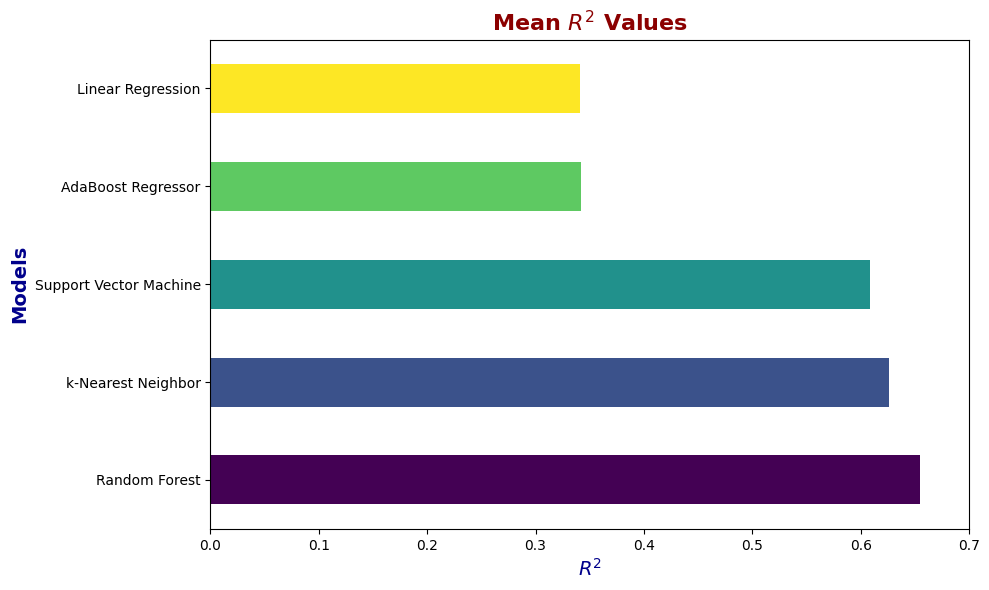

In [47]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_r2 = results_df['Mean R^2'].sort_values()

# Create colors based on sorted values
colors_r2 = plt.cm.viridis(np.linspace(0, 1, len(sorted_r2)))

# Plot Mean R2 values
sorted_r2 = results_df['Mean R^2'].sort_values(ascending=False)
sorted_r2.plot(kind='barh', color=colors_r2)
plt.title('Mean $R^2$ Values', fontdict=title_font)
plt.xlabel('$R^2$', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 0.7)

#Save to pdf
plt.savefig('R^2_models-random.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

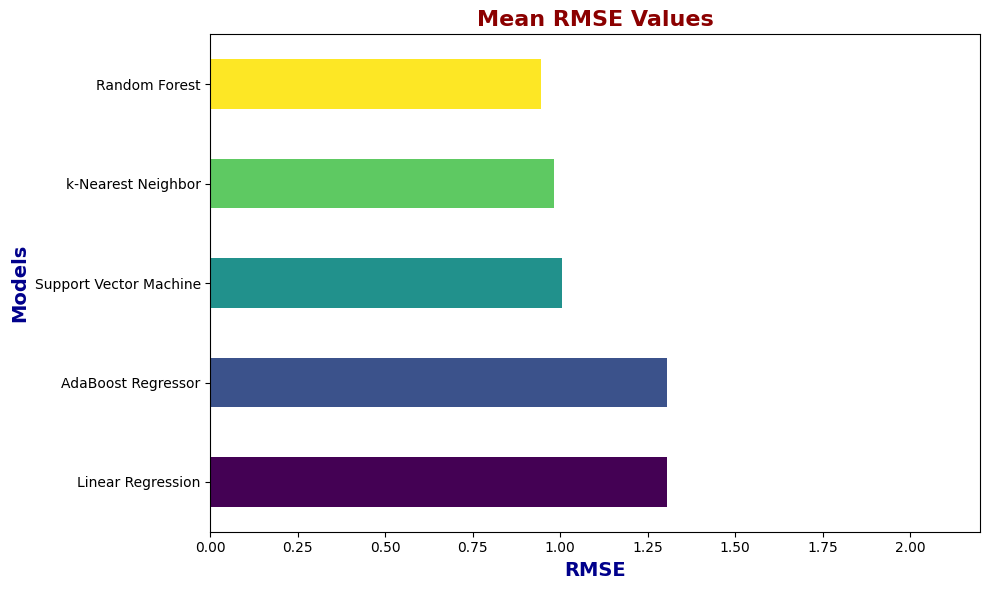

In [48]:
# Set up the figure
plt.figure(figsize = (10, 6))

# Sort the values
sorted_rmse = results_df['Mean RMSE'].sort_values()

# Create colors based on sorted values
colors_rmse = plt.cm.viridis(np.linspace(0, 1, len(sorted_rmse)))

# Plot Mean RMSE values
sorted_rmse = results_df['Mean RMSE'].sort_values(ascending=False)
sorted_rmse.plot(kind='barh', color=colors_rmse)
plt.title('Mean RMSE Values', fontdict=title_font)
plt.xlabel('RMSE', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0,2.2)

#Save to pdf
plt.savefig('RMSE_models-random.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

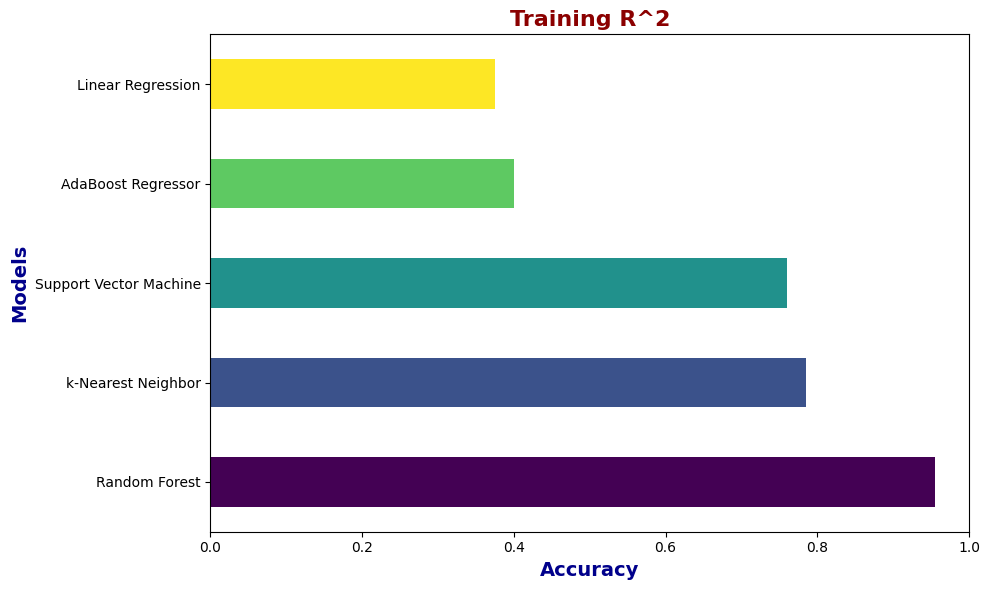

In [49]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Sort the values
sorted_acc = results_df['Training R^2'].sort_values()

# Create colors based on sorted values
colors_acc = plt.cm.viridis(np.linspace(0, 1, len(sorted_acc)))

# Plot Training R^2
sorted_accuracy = results_df['Training R^2'].sort_values(ascending=False)
sorted_accuracy.plot(kind='barh', color=colors_acc)
plt.title('Training R^2', fontdict=title_font)
plt.xlabel('Accuracy', fontdict=axis_font)
plt.ylabel('Models', fontdict=axis_font)
plt.xlim(0, 1)

#Save to pdf
plt.savefig('Training_R2-random.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

## Feature Importance

In [50]:
# Extract feature importances
feature_importances = models['Random Forest'].feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
sorted_features_df = features_df.sort_values(by='Importance', ascending=False)
sorted_features_df[:20]

,Feature,Importance
131,PEOE_VSA7,0.068718
152,EState_VSA5,0.061469
84,SdssC,0.035415
25,GATS1s,0.033983
8,ATSC5dv,0.031795
142,SlogP_VSA1,0.028671
2,VE1_A,0.028345
132,PEOE_VSA8,0.027430
158,VSA_EState3,0.027276
146,SlogP_VSA10,0.017776


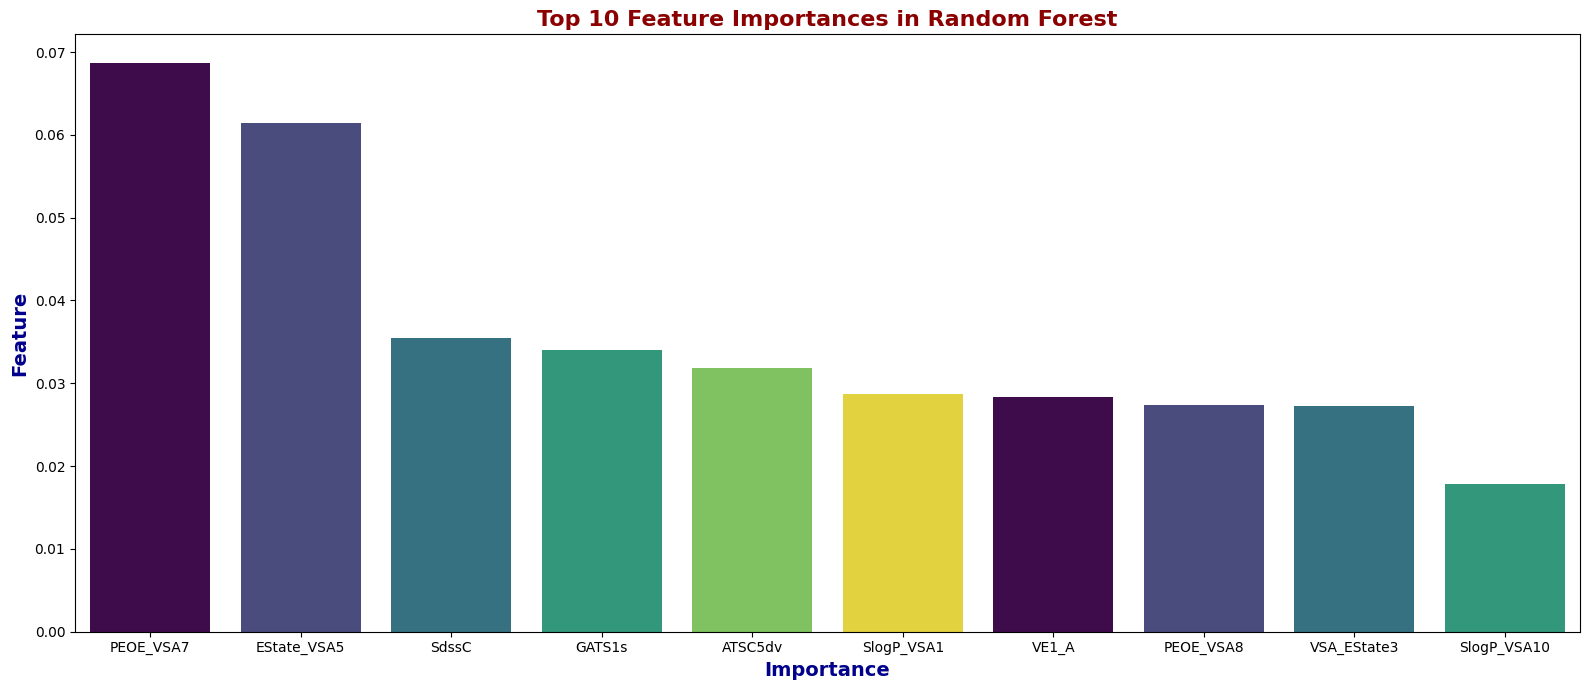

In [51]:
# Set the plot
plt.figure(figsize=(16, 7))

# Set the color
color = plt.cm.viridis(np.linspace(0, 1, 6))

# Plot the top 6 features using seaborn
sns.barplot(y='Importance', x='Feature', data=sorted_features_df.iloc[:10], palette=color)

plt.title('Top 10 Feature Importances in Random Forest', fontdict=title_font)
plt.xlabel('Importance', fontdict=axis_font)
plt.ylabel('Feature',fontdict=axis_font)
plt.xticks

#Save to pdf
plt.savefig('Features_importance-random.pdf', bbox_inches = 'tight')

# Adjust the layout
plt.tight_layout()
plt.show()

## Predictions

In [52]:
X_test.head()

,nAcid,nBase,VE1_A,nSpiro,nBridgehead,nB,AATS3i,AATS4i,ATSC5dv,ATSC6dv,...,n6FAHRing,n9FAHRing,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL400092,-0.129864,0.244687,0.224501,-0.194776,-0.206928,0.0,-0.739006,-0.671294,0.580067,0.139186,...,0.0,-0.23739,-0.031380,1.302318,0.364804,1.130234,0.238122,-0.306022,-2.112724,-1.828599
CHEMBL2088786,-0.129864,0.244687,-1.078179,-0.194776,-0.206928,0.0,0.849386,1.046344,0.860037,0.328987,...,0.0,-0.23739,-0.967669,-0.059736,-0.771878,-1.122943,-0.256660,-0.341875,-0.629151,-0.038172
CHEMBL4555818,-0.129864,0.244687,-0.489895,-0.194776,-0.206928,0.0,0.942807,0.421622,-0.695074,-0.355686,...,0.0,-0.23739,-0.312075,-0.632535,-0.469635,-0.151887,-0.580227,-0.378650,-0.429542,-0.459984
CHEMBL104355,-0.129864,0.244687,-0.854242,-0.194776,-0.206928,0.0,0.791537,1.317408,-0.315159,-0.841525,...,0.0,-0.23739,0.672440,-0.187342,0.364555,-0.775507,-0.040892,-0.033928,0.163164,0.512191
CHEMBL3787502,-0.129864,-1.080115,-0.832172,-0.194776,-0.206928,0.0,-0.060893,0.928466,0.196907,0.805211,...,0.0,-0.23739,-0.847394,1.244264,0.559786,1.403431,1.700877,1.895369,1.354235,-1.828599


In [53]:
y_pred = models['Random Forest'].predict(X_test)

In [54]:
y_pred

array([-0.88999861,  0.75619152,  1.01342638, ..., -0.2165203 ,
        0.72416195, -0.9853874 ])

In [55]:
# Reshape y_pred for inverse transformation
y_pred_reshaped = y_pred.reshape(-1, 1)

# Reverse the scaling
reversed_y_pred = pic50_scaler.inverse_transform(y_pred_reshaped)
reversed_y_pred

array([[-4.54991669],
       [-1.89035373],
       [-1.4747685 ],
       ...,
       [-3.46185406],
       [-1.94210027],
       [-4.70402556]])

In [56]:
actual_values = data.loc[data.index.isin(y_test.index)]

In [57]:
# Reorder actual_values to have the same index order as y_test
actual_values_reordered = actual_values.loc[y_test.index]
actual_values_reordered

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL400092,OC1C=C2CCN3Cc4cc5c(cc4C(C1O)C23)OCO5,inactive,0,-5.190332,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fac5cb0>
CHEMBL2088786,N#Cc1cc(C#N)c(NCCCCC2CCN(Cc3ccccc3)CC2)nc1N,active,1,-1.845098,,<rdkit.Chem.rdchem.Mol object at 0x7e3c602310e0>
CHEMBL4555818,NC(Cc1c[nH]c2ccccc12)C(=O)NCCCCCCCNc1c2c(nc3cc...,active,1,-1.278754,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601b90e0>
CHEMBL104355,CN(C)Cc1ccc(CSCCNc2ccc(F)cc2[N+](=O)[O-])o1,active,1,-2.812913,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601594d0>
CHEMBL3787502,COc1ccc2c(c1)CC(NC(=O)N(C)C)CC2,active,1,-1.350442,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601bb220>
...,...,...,...,...,...,...
CHEMBL3753360,c1ccc2oc(CN(CCCCCCCNc3c4c(nc5ccccc35)CCCC4)Cc3...,active,1,-2.068186,,<rdkit.Chem.rdchem.Mol object at 0x7e3c6026e340>
CHEMBL3965046,CCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC2)CC1,inactive,0,-4.491362,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fa05540>
CHEMBL151861,C#CC(C)NCCc1cccc(OC(=O)N(C)C)c1,active,1,-2.230449,,<rdkit.Chem.rdchem.Mol object at 0x7e3c600a4350>


In [76]:
# Compare if the indexes are the same
indexes_are_equal = y_test.index.equals(actual_values_reordered.index)

print(indexes_are_equal)

True


### RMSE and R^2<a name = 25></a>

In [60]:
# Extract actual experimental results
actual_values = actual_values_reordered['pIC50']

# Calculate metrics
rmse_rf = mean_squared_error(actual_values, reversed_y_pred, squared=False)
r2_rf = r2_score(actual_values, reversed_y_pred)

rmse_rf, r2_rf

(0.9374738984304738, 0.6726605690588576)

### Scatter Plot<a name = 26></a>

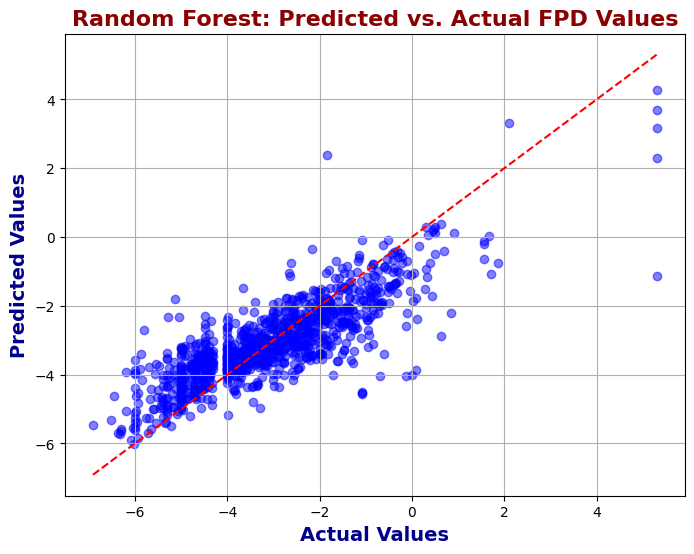

In [61]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, reversed_y_pred, alpha=0.5, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs. Actual FPD Values', fontdict=title_font)
plt.xlabel('Actual Values', fontdict=axis_font)
plt.ylabel('Predicted Values', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_predicted_vs_actual-random.pdf", bbox_inches='tight')
plt.show()

### Residual Plot<a name = 27></a>

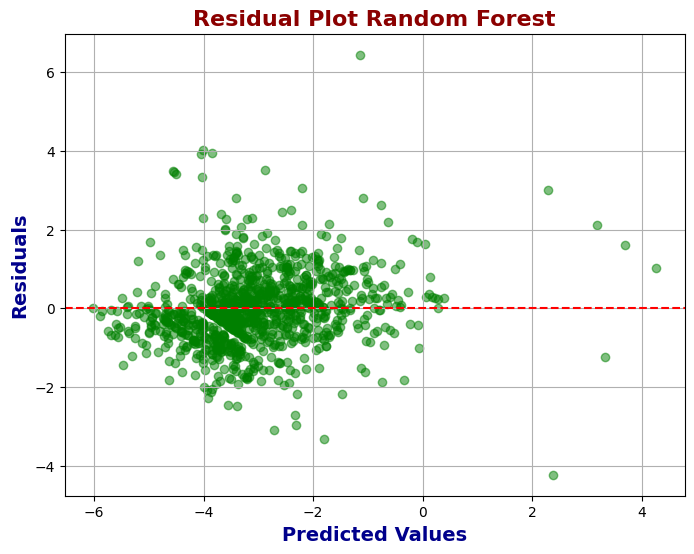

In [62]:
# Residual plot
residuals = actual_values - reversed_y_pred.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(reversed_y_pred, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Random Forest', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("RF_residuals-random.pdf", bbox_inches='tight')
plt.show()

### Absolute Difference<a name = 28></a>

In [63]:
# Create a DataFrame with actual and predicted values
comparison_df_rf = pd.DataFrame({
    'Actual Values': actual_values,
    'Predicted Values': reversed_y_pred.flatten(),
    'Absolute Difference': abs(actual_values - reversed_y_pred.flatten())
})

# Display the first few rows of the DataFrame
print(comparison_df_rf.head())

                    Actual Values  Predicted Values  Absolute Difference
molecule_chembl_id                                                      
CHEMBL400092            -5.190332         -4.549917             0.640415
CHEMBL2088786           -1.845098         -1.890354             0.045256
CHEMBL4555818           -1.278754         -1.474768             0.196014
CHEMBL104355            -2.812913         -2.845471             0.032558
CHEMBL3787502           -1.350442         -2.055206             0.704764


In [64]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison_df_rf["Absolute Difference"].describe()

difference_statistics

count    1093.000000
mean        0.680083
std         0.645543
min         0.000216
25%         0.223044
50%         0.502792
75%         0.961125
max         6.442776
Name: Absolute Difference, dtype: float64

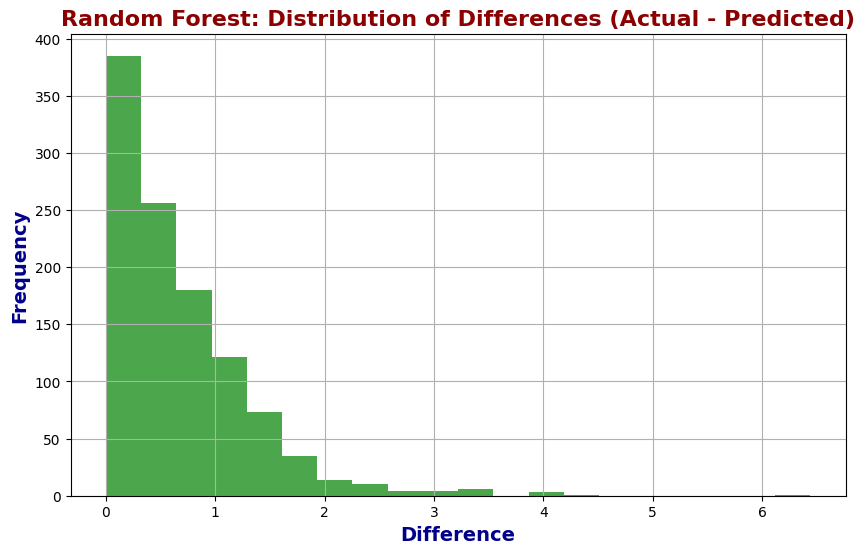

In [65]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison_df_rf["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Random Forest: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_difference-random.pdf", bbox_inches='tight')

plt.show()

In [66]:
comparison_df_rf

,Actual Values,Predicted Values,Absolute Difference
molecule_chembl_id,,,
CHEMBL400092,-5.190332,-4.549917,0.640415
CHEMBL2088786,-1.845098,-1.890354,0.045256
CHEMBL4555818,-1.278754,-1.474768,0.196014
CHEMBL104355,-2.812913,-2.845471,0.032558
CHEMBL3787502,-1.350442,-2.055206,0.704764
...,...,...,...
CHEMBL3753360,-2.068186,-2.083523,0.015337
CHEMBL3965046,-4.491362,-3.996975,0.494387
CHEMBL151861,-2.230449,-3.461854,1.231405


In [67]:
comparison_df_rf.to_csv('test_predicted_vs_actual_vs_difference-random.csv', index=True)

In [68]:
actual_values_reordered = pd.DataFrame(actual_values_reordered, columns = ['pIC50'])
actual_values_reordered

,pIC50
molecule_chembl_id,
CHEMBL400092,-5.190332
CHEMBL2088786,-1.845098
CHEMBL4555818,-1.278754
CHEMBL104355,-2.812913
CHEMBL3787502,-1.350442
...,...
CHEMBL3753360,-2.068186
CHEMBL3965046,-4.491362
CHEMBL151861,-2.230449


In [69]:
reversed_y_pred_df = pd.DataFrame(reversed_y_pred, columns = ['predicted pIC50'])
reversed_y_pred_df = reversed_y_pred_df.set_index(y_test.index)
reversed_y_pred_df

,predicted pIC50
molecule_chembl_id,
CHEMBL400092,-4.549917
CHEMBL2088786,-1.890354
CHEMBL4555818,-1.474768
CHEMBL104355,-2.845471
CHEMBL3787502,-2.055206
...,...
CHEMBL3753360,-2.083523
CHEMBL3965046,-3.996975
CHEMBL151861,-3.461854


In [70]:
y_test_molecules = data.loc[data.index.isin(reversed_y_pred_df.index)]
y_test_molecules

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL4543251,O=C(CCCCCNc1c2c(nc3ccc(F)cc13)CCCC2)NCCc1c[nH]...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b77d0>
CHEMBL4590945,O=C(CCCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCC...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b7b50>
CHEMBL382260,COc1ccc2[nH]cc(CCNC(=O)CCCCCCNc3c4c(nc5ccccc35...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7e3c605b7df0>
CHEMBL4455677,COc1ccc2[nH]cc(CCNC(=O)CCCCNc3c4c(nc5ccccc35)C...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7e3c6031c040>
CHEMBL383663,O=C(CCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)NCCc1c[nH...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7e3c6031c510>
...,...,...,...,...,...,...
CHEMBL3261992,O=C(C=NO)Nc1ccc[n+](Cc2ccc(C[n+]3cccc(NC(=O)C=...,inactive,0,-6.322219,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5f932730>
CHEMBL341956,C[N+](C)(C)CCCl,inactive,0,-6.378000,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5f932ab0>
CHEMBL3597060,CC(C)(C)OC(=O)C1C(=Nc2ccccc2)CC(c2ccccc2)N(c2c...,inactive,0,-6.445604,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5f932ea0>


In [71]:
# Reorder actual_values to have the same index order as y_test
y_test_molecules = y_test_molecules.loc[reversed_y_pred_df.index]
y_test_molecules

,curated_smiles,class,Label,pIC50,ID,Molecule
molecule_chembl_id,,,,,,
CHEMBL400092,OC1C=C2CCN3Cc4cc5c(cc4C(C1O)C23)OCO5,inactive,0,-5.190332,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fac5cb0>
CHEMBL2088786,N#Cc1cc(C#N)c(NCCCCC2CCN(Cc3ccccc3)CC2)nc1N,active,1,-1.845098,,<rdkit.Chem.rdchem.Mol object at 0x7e3c602310e0>
CHEMBL4555818,NC(Cc1c[nH]c2ccccc12)C(=O)NCCCCCCCNc1c2c(nc3cc...,active,1,-1.278754,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601b90e0>
CHEMBL104355,CN(C)Cc1ccc(CSCCNc2ccc(F)cc2[N+](=O)[O-])o1,active,1,-2.812913,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601594d0>
CHEMBL3787502,COc1ccc2c(c1)CC(NC(=O)N(C)C)CC2,active,1,-1.350442,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601bb220>
...,...,...,...,...,...,...
CHEMBL3753360,c1ccc2oc(CN(CCCCCCCNc3c4c(nc5ccccc35)CCCC4)Cc3...,active,1,-2.068186,,<rdkit.Chem.rdchem.Mol object at 0x7e3c6026e340>
CHEMBL3965046,CCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC2)CC1,inactive,0,-4.491362,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fa05540>
CHEMBL151861,C#CC(C)NCCc1cccc(OC(=O)N(C)C)c1,active,1,-2.230449,,<rdkit.Chem.rdchem.Mol object at 0x7e3c600a4350>


In [78]:
y_test_mol = pd.concat([y_test_molecules, reversed_y_pred_df], axis=1)

In [79]:
y_test_mol

,curated_smiles,class,Label,pIC50,ID,Molecule,predicted pIC50
molecule_chembl_id,,,,,,,
CHEMBL400092,OC1C=C2CCN3Cc4cc5c(cc4C(C1O)C23)OCO5,inactive,0,-5.190332,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fac5cb0>,-4.549917
CHEMBL2088786,N#Cc1cc(C#N)c(NCCCCC2CCN(Cc3ccccc3)CC2)nc1N,active,1,-1.845098,,<rdkit.Chem.rdchem.Mol object at 0x7e3c602310e0>,-1.890354
CHEMBL4555818,NC(Cc1c[nH]c2ccccc12)C(=O)NCCCCCCCNc1c2c(nc3cc...,active,1,-1.278754,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601b90e0>,-1.474768
CHEMBL104355,CN(C)Cc1ccc(CSCCNc2ccc(F)cc2[N+](=O)[O-])o1,active,1,-2.812913,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601594d0>,-2.845471
CHEMBL3787502,COc1ccc2c(c1)CC(NC(=O)N(C)C)CC2,active,1,-1.350442,,<rdkit.Chem.rdchem.Mol object at 0x7e3c601bb220>,-2.055206
...,...,...,...,...,...,...,...
CHEMBL3753360,c1ccc2oc(CN(CCCCCCCNc3c4c(nc5ccccc35)CCCC4)Cc3...,active,1,-2.068186,,<rdkit.Chem.rdchem.Mol object at 0x7e3c6026e340>,-2.083523
CHEMBL3965046,CCN1CCN(C2CCN(C(=O)COc3ccc(-c4ccccc4)cc3)CC2)CC1,inactive,0,-4.491362,,<rdkit.Chem.rdchem.Mol object at 0x7e3c5fa05540>,-3.996975
CHEMBL151861,C#CC(C)NCCc1cccc(OC(=O)N(C)C)c1,active,1,-2.230449,,<rdkit.Chem.rdchem.Mol object at 0x7e3c600a4350>,-3.461854


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


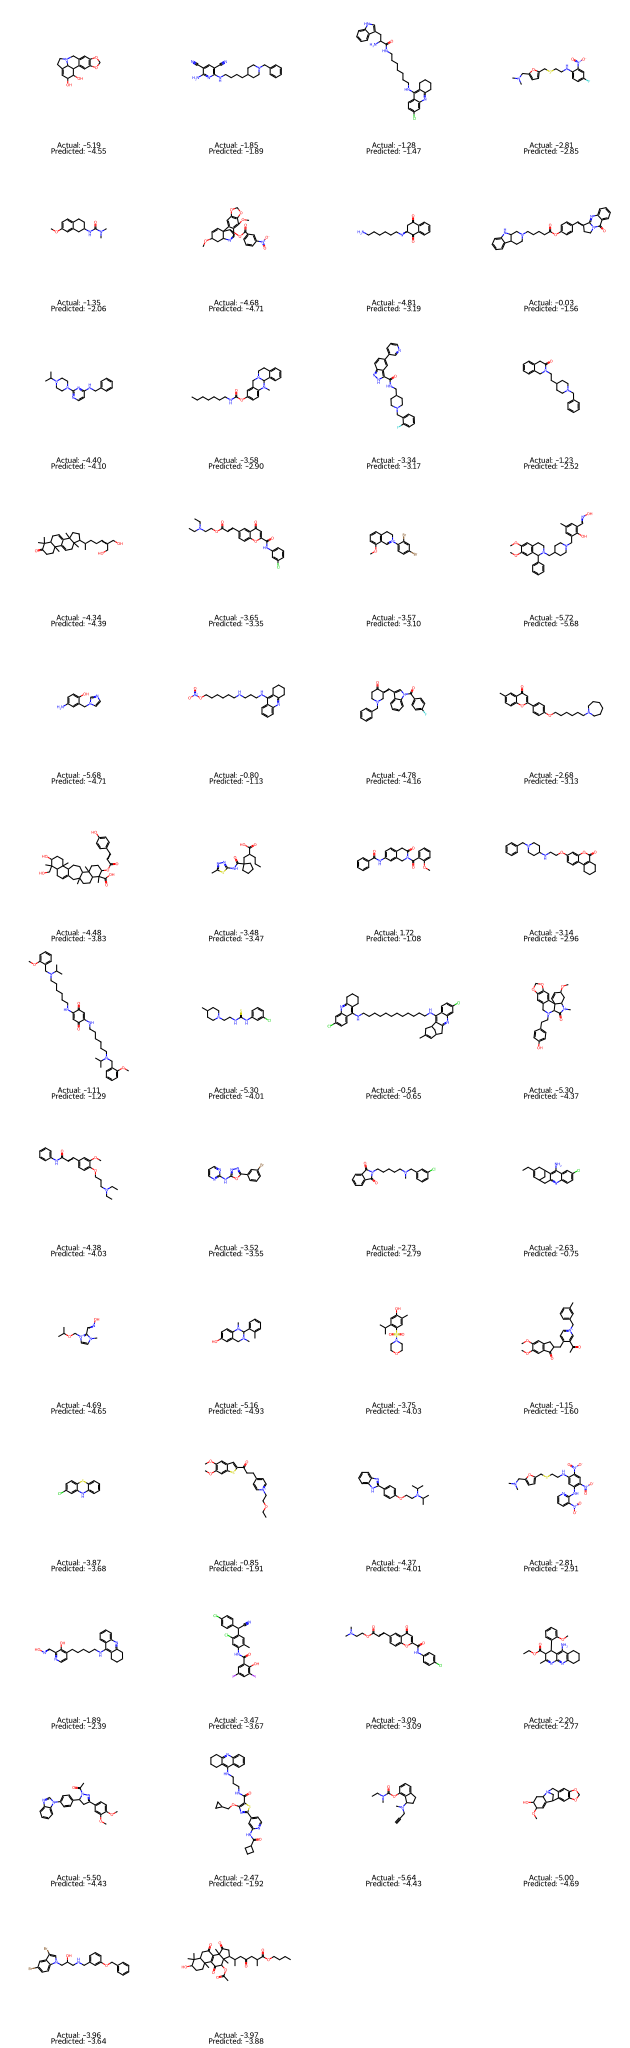

In [82]:
from rdkit.Chem import Draw
import cairosvg

# Step 1: Create the legends list
legends = y_test_mol.apply(lambda row: f"Actual: {row['pIC50']:.2f}\nPredicted: {row['predicted pIC50']:.2f}", axis=1).tolist()

# Step 2: Generate the SVG image
img_svg = Draw.MolsToGridImage(y_test_mol['Molecule'],
                               subImgSize=(300,300),
                               molsPerRow=4,
                               legends=legends,
                               useSVG=True)


# Save the SVG image to a file
svg_filename = "Molecules_predicted_vs_Observed-random.svg"
with open(svg_filename, "w") as f:
    f.write(img_svg.data)


# Convert the SVG to PDF
pdf_filename = svg_filename.replace(".svg", ".pdf")
cairosvg.svg2pdf(url=svg_filename, write_to=pdf_filename)

# Display the generated image
img_svg

## 7. Conclusions

The predictive model using the train-test-split from scikit-learn, without applying any pre-conditoned to split the data, as it was done in notebook 4.1, gives much better predictions of the pIC50. However, this doesn't mean this methods is better, it only illustrates the importance of the method used to split the data. This decision has to be system dependen and according with the analysis of the data and personal objectives.

Perspective: The model will have to be further optimized in order to be used as a predictive model.

